## Image segmentation with U-Net

This part of the homework is about image segmentation with <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

### What is image segmentation?

There is a large number of tasks where you need to know not only the presence of an object in the picture, but its location and exact shape.This is precisely the task that image segmentation copes with, which puts a class label for each pixel, as opposed to image classification, which labels each image.

This task uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the train and test split). Each pixel of an animal image corresponds to one of three classes: a pixel belonging to a pet; a pixel located at the border of a pet; all other pixels. 

Данное задание предстоит выполнить на фреймворке Tensorflow 2 с помощью Ke ras, подробнее о том, как использовать Keras и примеры вы можете найти по [ссылке](https://www.tensorflow.org/guide/keras/sequential_model)

### Preprocessing

#### Download the data

Please make sure you select the **GPU** runtime environment!!!

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  28.0M      0  0:00:26  0:00:26 --:--:-- 29.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0   9.7M      0  0:00:01  0:00:01 --:--:--  9.7M


#### Prepare paths of input images

In [2]:
import os 

def get_paths(files_dir: str, files_type: str):
    paths = sorted(
        [
            os.path.join(files_dir, file_name)
            for file_name in os.listdir(files_dir)
            if file_name.endswith(f".{files_type}") and not file_name.startswith(".")
        ]
    )
    return paths


images_dir = "images/"
masks_dir = "annotations/trimaps/"

images_paths = get_paths(images_dir, "jpg")
masks_paths = get_paths(masks_dir, "png")

img_size = (128, 128)
num_classes = 3

print("Number of samples:", len(images_paths))

Number of samples: 7390


#### Show example of data

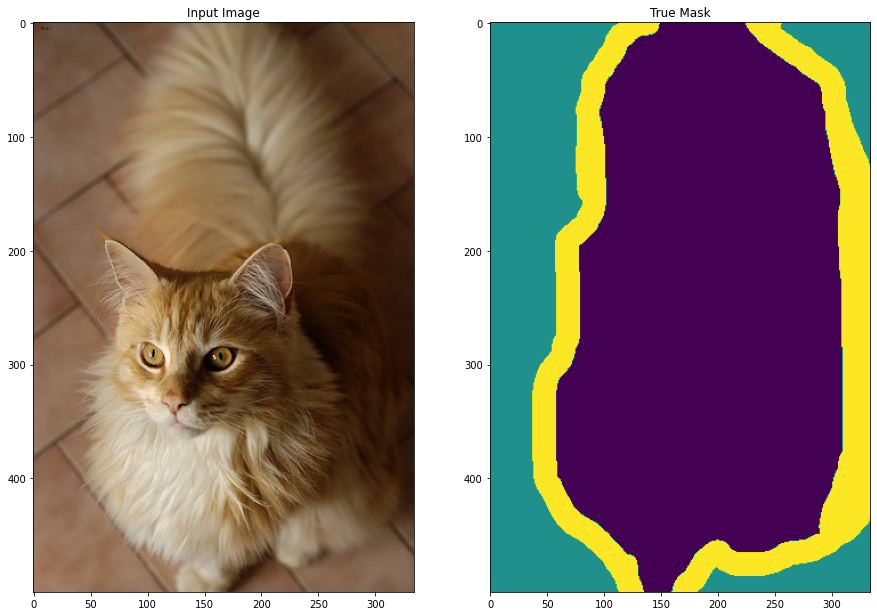

In [3]:
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

import numpy as np
import matplotlib.pyplot as plt

# display original image, true mask, and predicted mask (optional)
# all images are np.arrays or PIL.Image
def display_sample(display_list):
    titles = ['Input Image', 'True Mask', 'Predicted Mask'][:len(display_list)]
    plt.figure(figsize=(15, 15))
    columns = len(titles)
    
    for i, image in enumerate(display_list):
        plt.subplot(1, columns, i + 1)
        plt.title(titles[i])
        plt.imshow(np.asarray(image))
    
def load_image_and_mask(images_paths, masks_paths, ind, tar_size = None):
    image = load_img(images_paths[ind], target_size = tar_size)
    #mask = PIL.ImageOps.autocontrast(load_img(masks_paths[ind]))
    mask = load_img(masks_paths[ind], color_mode="grayscale", target_size = tar_size)
    return (image, mask, )

sample = load_image_and_mask(images_paths, masks_paths, 1234)
display_sample(sample)

#### Task 1: Set Sequence for training process

In this task you need to implement two methods for the Sequence class used for model training and validation: __len__ and __getitem__.



Note: `Sequence` are a safer way to do multiprocessing. This structure guarantees
that the network will only train once
on each sample per epoch which is not the case with generators.

In [4]:
from tensorflow import keras



class PetsSequence(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, images_paths, masks_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        if len(self.images_paths) != len(self.masks_paths):
          raise ValueError('Numbers of images and masks are not the same')
        
    
    def __len__(self):
        # Each item in the sequence has a size of batch_size, this method returns the number of batches. Shoud be integer!
        # TODO: length calculation
        length = len(self.images_paths)/self.batch_size
        return int(length)
    
    def __getitem__(self, idx):
        x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype="float32")
        y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype="uint8")
        """
        This method returns the batches themselves including images (x) and masks (y) as np.arrays.
        Correspondingly x contains the batch_size of the pet images, y the true segmentation of the images from x.
        Note:
            1) You can use tensorflow.keras.preprocessing.image.load_img with the specified parameter "target_size" 
                (for reading masks for reading masks is a convenient is parametercolor_mode="grayscale")
            2) Don't forget to normalize the images and masks 
                ( img / 255.0 for images, so that each value is adjacent to the interval [0, 1] 
                and mask -= 1 for segmented images, to get {0, 1, 2} instead of the original labels {1, 2, 3} ) 
        """
        
        # TODO x and y calculation
        # X contains three channels, Y contains only one 
        start = idx * self.batch_size
        end = start + self.batch_size
        for i in range(start, end):
          local_id = i - start
          if i == len(self.images_paths):
            break
          img, mask = load_image_and_mask(self.images_paths, self.masks_paths, i, tar_size = (128, 128))
          x[local_id, :, :, :] = keras.preprocessing.image.img_to_array(img)/255.0
          y[local_id, :, :, :] = keras.preprocessing.image.img_to_array(mask) - 1
        
        return x, y
        

Test for task 1. Please do not change the code in the cell below, it is just to make sure that your implementation of Sequence is set correctly

In [5]:
sequence = PetsSequence(32, (128, 128), images_paths, masks_paths)


if type(sequence.__len__()) != int:
    print("Error: __len__ value should be integer \n")
elif not (sequence.__len__() == 230 or sequence.__len__() == 231):
    print("Wrong answer for __len__ realization\n")
else:
    print("Method __len__ is correct!")
    
if len(sequence.__getitem__(5)) != 2:
    print("Error: __getitem__ Must return a tuple of two elements") 
else:
    x, y = sequence.__getitem__(5)
    if type(x) != np.ndarray or type(y) != np.ndarray:
        print("Error: x and y shoud have type numpy.ndarray")
    elif x.shape != (32, 128, 128, 3):
        print("Error: x shoud has shape (batch_size, img_size_x, img_size_y, 3)")
    elif y.shape != (32, 128, 128, 1):
        print("Error: y shoud has shape (batch_size, img_size_x, img_size_y, 1)")
    elif y.sum() == 962964:
        print("Wrong answer: there is no normalization for y")
    elif y.sum() != 438676:
        print("Wrong answer for y")
    elif x.sum() >= 167121500.0 and x.sum() <= 167122500.0:
        print("Wrong answer: there is no normalization for x")
    elif not (x.sum() >= 655200.0 and x.sum() <= 655600.0):
        print("Wrong answer for x")
    else:
        print("Method __getitem__ is correct!")

Method __len__ is correct!
Method __getitem__ is correct!


### Base U-Net

#### Task 2: U-Net architecture

In this task you need to describe the architecture of the neural network by implementing the get_unet_model method.

Note: You can use padding="same" in convolution layers to simplify the network structure and avoid cropping.

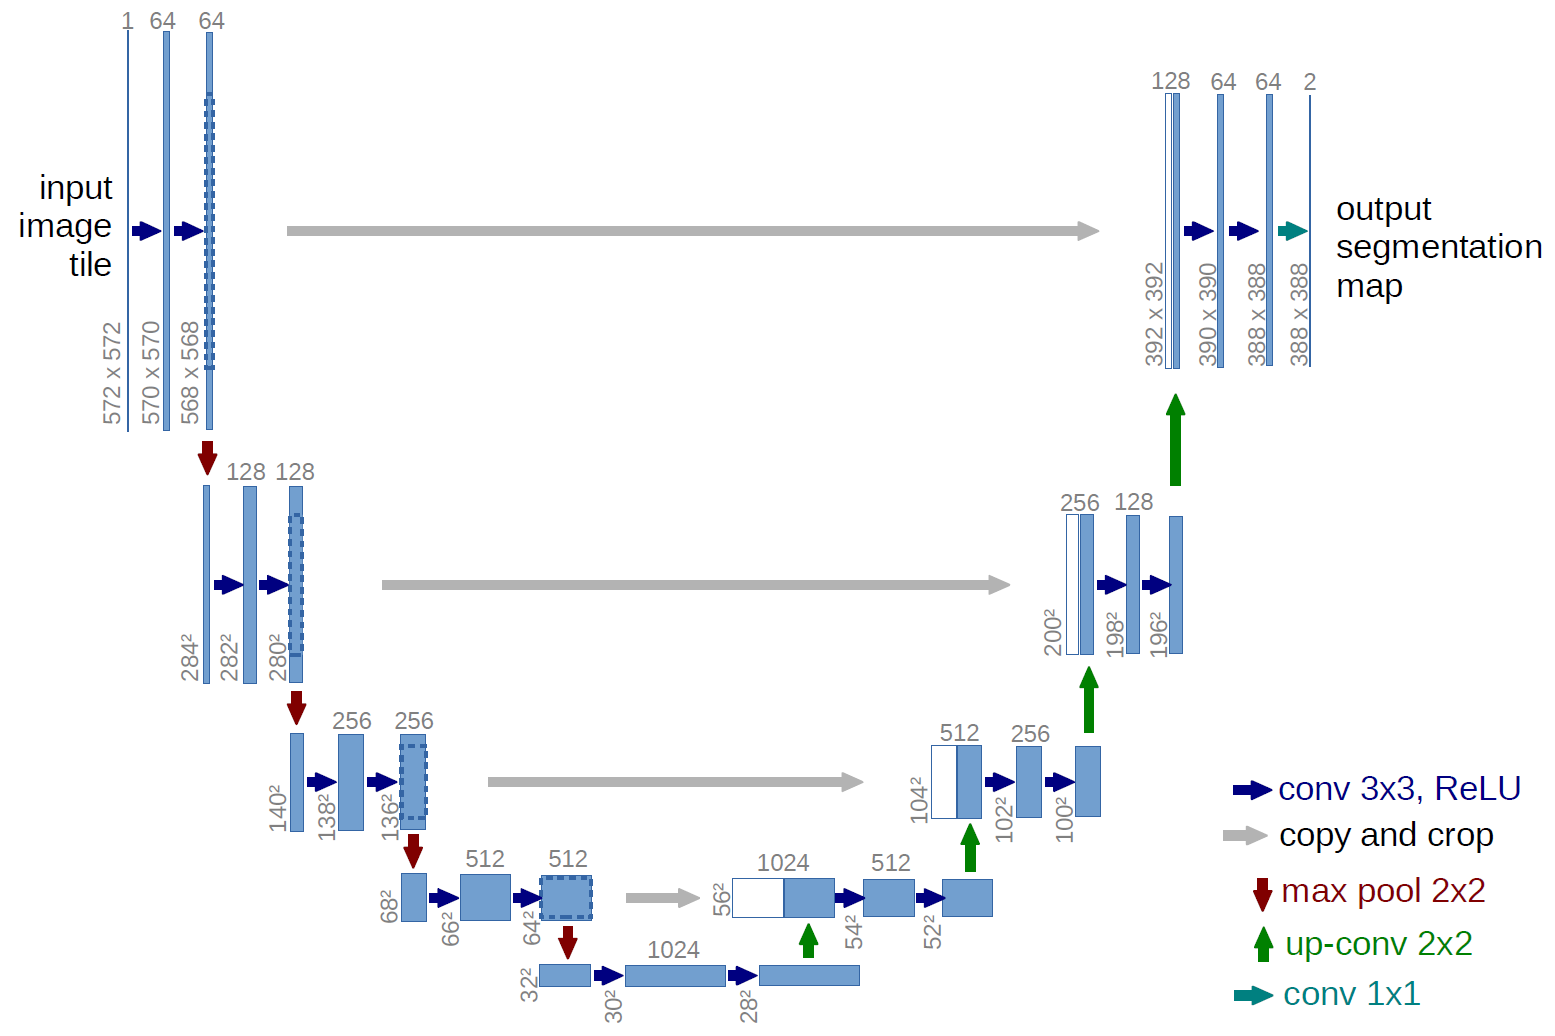



In this task you will be able to use MaxPooling2D(pool_size=(2, 2)), UpSampling2D(size = (2,2)), Concatenate().

In [6]:
from tensorflow.keras.layers import Input, Conv2D, Concatenate, MaxPooling2D, UpSampling2D

def get_unet_model(img_size, num_classes):
 
    inputs = keras.Input(shape=img_size+(3,))
    
    # --- Encoder ---
    # first conv layer
    print('inputs shape', inputs.shape) #none because of unknown of batch size
    conv_layer_1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    print('conv_layer_1 shape', conv_layer_1.shape) 
    # TODO other layers of encoder
    conv_layer_2 = Conv2D(64, 3, activation='relu', padding='same')(conv_layer_1)
    print('conv_layer_2 shape', conv_layer_2.shape) 
    pooling_layer_1 = MaxPooling2D(pool_size=(2,2))(conv_layer_2)
    print('pooling_layer_1 shape', pooling_layer_1.shape) 

    conv_layer_3 = Conv2D(128, 3, activation='relu', padding='same')(pooling_layer_1)
    print('conv_layer_3 shape', conv_layer_3.shape) 
    conv_layer_4 = Conv2D(128, 3, activation='relu', padding='same')(conv_layer_3)
    print('conv_layer_4 shape', conv_layer_4.shape) 
    pooling_layer_2 = MaxPooling2D(pool_size=(2,2))(conv_layer_4)
    print('pooling_layer_2 shape', pooling_layer_2.shape) 

    conv_layer_5 = Conv2D(256, 3, activation='relu', padding='same')(pooling_layer_2)
    print('conv_layer_5 shape', conv_layer_5.shape) 
    conv_layer_6 = Conv2D(256, 3, activation='relu', padding='same')(conv_layer_5)
    print('conv_layer_6 shape', conv_layer_6.shape) 
    pooling_layer_3 = MaxPooling2D(pool_size=(2,2))(conv_layer_6)
    print('pooling_layer_3 shape', pooling_layer_3.shape)
    
    conv_layer_7 = Conv2D(512, 3, activation='relu', padding='same')(pooling_layer_3)
    print('conv_layer_7 shape', conv_layer_7.shape) 
    conv_layer_8 = Conv2D(512, 3, activation='relu', padding='same')(conv_layer_7)
    print('conv_layer_8 shape', conv_layer_8.shape) 
    pooling_layer_4 = MaxPooling2D(pool_size=(2,2))(conv_layer_8)
    print('pooling_layer_4 shape', pooling_layer_4.shape)

    conv_layer_9 = Conv2D(1024, 3, activation='relu', padding='same')(pooling_layer_4)
    print('conv_layer_9 shape', conv_layer_9.shape) 
    last_covv_layer = Conv2D(1024, 3, activation='relu', padding='same')(conv_layer_9)
    print('last_covv_layer shape', last_covv_layer.shape) 
    print('decoder finish')
    # --- End of Encoder
    # --- Decoder --- 
    
    up_dec = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(last_covv_layer))
    # TODO other layers of decoder
    print('up_dec shape', up_dec.shape) 
    up_conv_layer_1 = Conv2D(512, 3, activation='relu', padding='same')(Concatenate()([up_dec, conv_layer_8]))
    print('up_conv_layer_1 shape', up_conv_layer_1.shape) 
    up_conv_layer_2 = Conv2D(512, 3, activation='relu', padding='same')(up_conv_layer_1)
    print('up_conv_layer_2 shape', up_conv_layer_2.shape) 

    up_dec2 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(up_conv_layer_2))
    print('up_dec2 shape', up_dec2.shape) 
    up_conv_layer_3 = Conv2D(256, 3, activation='relu', padding='same')(Concatenate()([up_dec2, conv_layer_6]))
    up_conv_layer_4 = Conv2D(256, 3, activation='relu', padding='same')(up_conv_layer_3)

    up_dec3 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(up_conv_layer_4))
    up_conv_layer_5 = Conv2D(128, 3, activation='relu', padding='same')(Concatenate()([up_dec3, conv_layer_4]))
    up_conv_layer_6 = Conv2D(128, 3, activation='relu', padding='same')(up_conv_layer_5)

    up_dec4 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(up_conv_layer_6))
    up_conv_layer_7 = Conv2D(64, 3, activation='relu', padding='same')(Concatenate()([up_dec4, conv_layer_2]))
    last_conv = Conv2D(64, 3, activation='relu', padding='same')(up_conv_layer_7)
    # --- End of Decoder ---
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(last_conv)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = get_unet_model(img_size, num_classes)

inputs shape (None, 128, 128, 3)
conv_layer_1 shape (None, 128, 128, 64)
conv_layer_2 shape (None, 128, 128, 64)
pooling_layer_1 shape (None, 64, 64, 64)
conv_layer_3 shape (None, 64, 64, 128)
conv_layer_4 shape (None, 64, 64, 128)
pooling_layer_2 shape (None, 32, 32, 128)
conv_layer_5 shape (None, 32, 32, 256)
conv_layer_6 shape (None, 32, 32, 256)
pooling_layer_3 shape (None, 16, 16, 256)
conv_layer_7 shape (None, 16, 16, 512)
conv_layer_8 shape (None, 16, 16, 512)
pooling_layer_4 shape (None, 8, 8, 512)
conv_layer_9 shape (None, 8, 8, 1024)
last_covv_layer shape (None, 8, 8, 1024)
decoder finish
up_dec shape (None, 16, 16, 512)
up_conv_layer_1 shape (None, 16, 16, 512)
up_conv_layer_2 shape (None, 16, 16, 512)
up_dec2 shape (None, 32, 32, 256)


You can check the correctness of the model by comparing the U-Net architecture and the output of keras.utils.plot_model

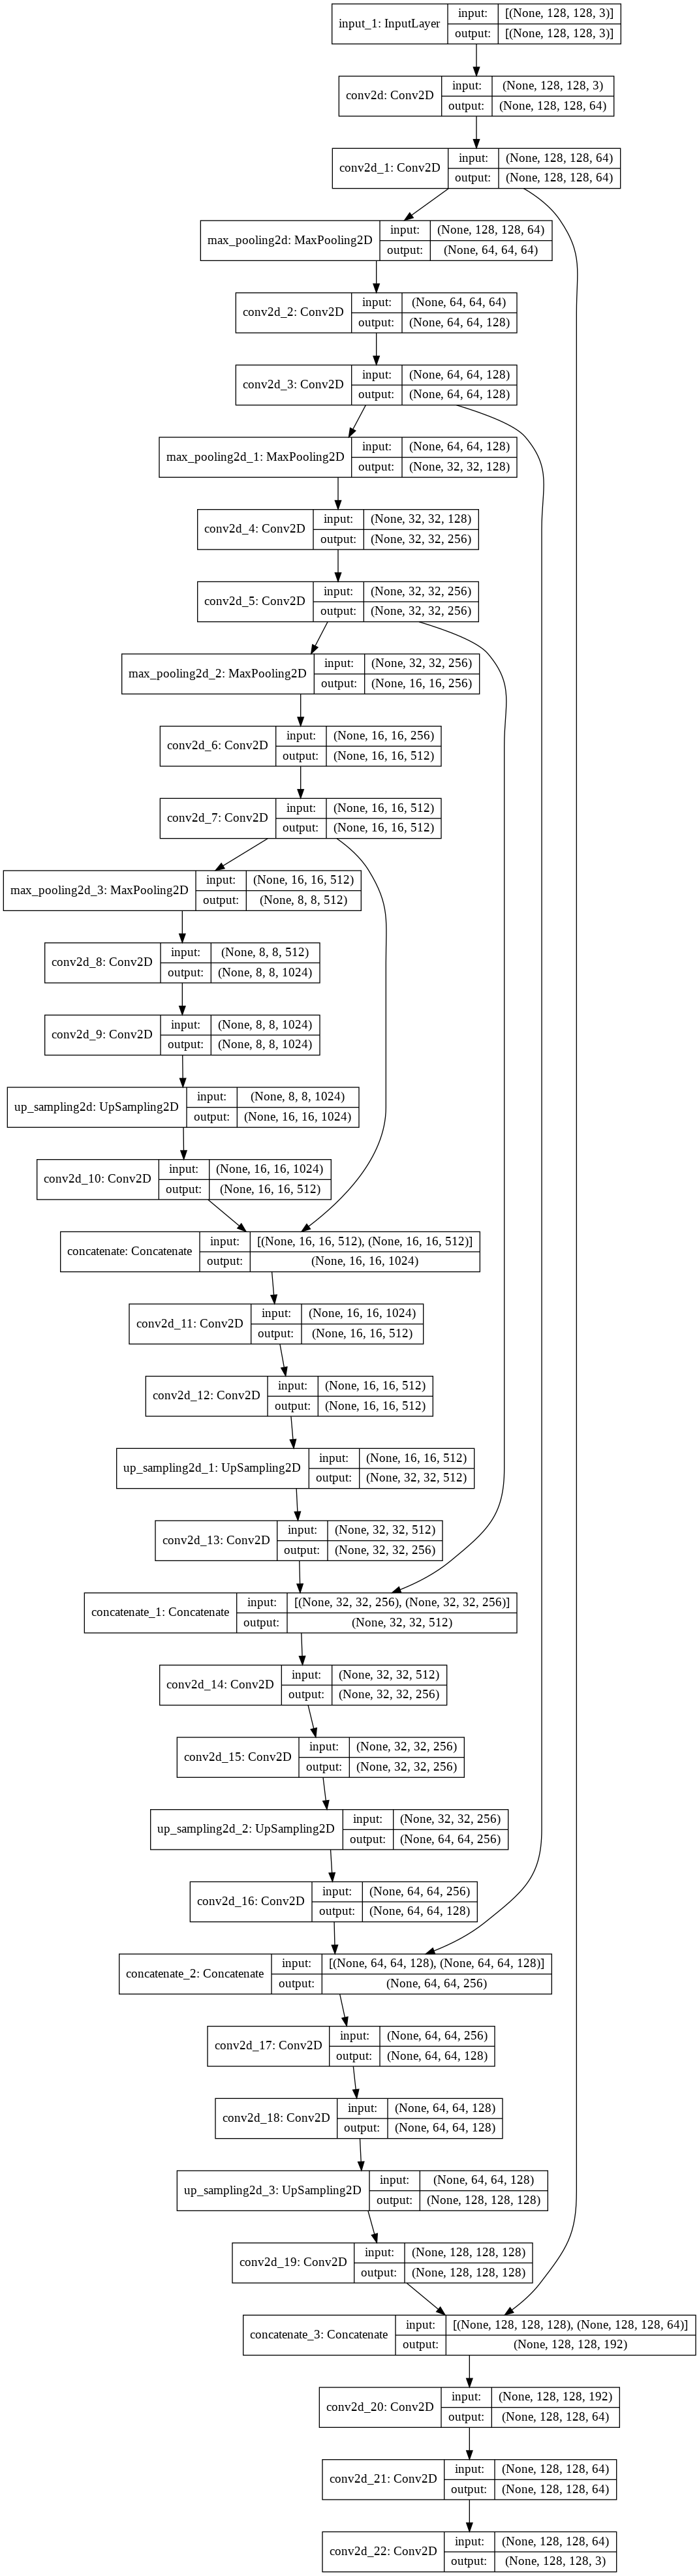

In [7]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [8]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(images_paths)
random.Random(1337).shuffle(masks_paths)
train_input_img_paths = images_paths[:-val_samples]
train_target_img_paths = masks_paths[:-val_samples]
val_input_img_paths = images_paths[-val_samples:]
val_target_img_paths = masks_paths[-val_samples:]

# Instantiate data Sequences for each split
batch_size = 32
train_gen = PetsSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")


# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 255s 1s/step - loss: 10.4168 - val_loss: 0.8479
Epoch 2/15
199/199 [==============================] - 233s 1s/step - loss: 0.9977 - val_loss: 0.7570
Epoch 3/15
199/199 [==============================] - 232s 1s/step - loss: 0.7473 - val_loss: 0.7411
Epoch 4/15
199/199 [==============================] - 233s 1s/step - loss: 0.8195 - val_loss: 1.2045
Epoch 5/15
199/199 [==============================] - 233s 1s/step - loss: 0.6300 - val_loss: 0.5280
Epoch 6/15
199/199 [==============================] - 233s 1s/step - loss: 0.6133 - val_loss: 0.5055
Epoch 7/15
199/199 [==============================] - 233s 1s/step - loss: 0.5711 - val_loss: 0.4615
Epoch 8/15
199/199 [==============================] - 233s 1s/step - loss: 0.5367 - val_loss: 0.4312
Epoch 9/15
199/199 [==============================] - 233s 1s/step - loss: 0.4956 - val_loss: 0.7520
Epoch 10/15
199/199 [==============================] - 233s 1s/step - loss: 0.4675 - val_l

In [9]:
# predict segmentation for validation dataset
# It is not necessary to predict the result for the whole dataset, you can limit yourself to one batch from the validation dataset 

val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

KeyboardInterrupt: ignored

In [17]:
def prediction_to_img(prediction):
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.expand_dims(prediction, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(prediction))
    return img 

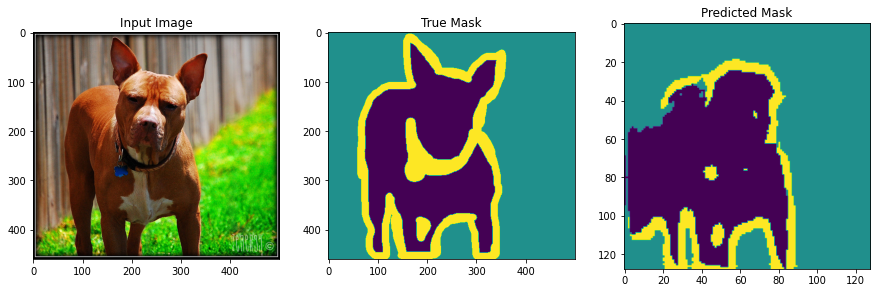

In [ ]:
# display one sample prediction

i = 7

sample = load_image_and_mask(val_input_img_paths, val_target_img_paths, i)
prediction = prediction_to_img(val_preds[i])
sample += (prediction,)

display_sample(sample)

### Using pretrained models for optimization of U-Net

#### Definition of U-Net encoder by pretrained MobileNetV2

We will use the already trained MobileNetV2 encoder for U-Net, and only the decoder will be trained in the process.

In [9]:
base_model = keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model (we have remembered layers which we will use for decoder)
down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

#### Task 3: U-Net architecture with MobileNetV2 encoder

In [10]:
# install tensorflow_examples
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-__0_bxk_
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-__0_bxk_


In [11]:
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.layers import Input, Conv2DTranspose, Concatenate, Conv2D
from tensorflow.keras import Sequential

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def get_unet_with_mobile_net_v2(img_size: list, num_classes:int):
    inputs = Input(shape=img_size + (3,))

    # pretrained encoder layer
    skips = down_stack(inputs)
    
    
    # --- Decoder --- 
    # the first part of the decoder
    up_dec = up_stack[0](skips[-1])
    #x = Concatenate()([x, skips[-2]])
    x = Concatenate()([up_dec, skips[-2]])

    # TODO: implement the remaining decoder layers

    up_seq_1 = Sequential(
        [
          Conv2D(512, 3, activation='relu', padding='same'),
          Conv2D(512, 3, activation='relu', padding='same'),
          UpSampling2D(size = (2,2)),
          Conv2D(256, 2, activation = 'relu', padding = 'same'),
        ], name = 'seq1'
    )

    x = up_seq_1(x)

    #up_conv_lay_1 = Conv2D(512, 3, activation='relu', padding='same')(x)
    #print('up_conv_lay_1 shape', up_conv_lay_1.shape) 
    #up_conv_lay_2 = Conv2D(512, 3, activation='relu', padding='same')(up_conv_lay_1)
    #print('v shape', up_conv_lay_2.shape) 

    #up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(up_conv_lay_2))
    #print('up_dec_2 shape', up_dec_2.shape) 

    x = Concatenate()([x, skips[-3]])

    up_seq_2 = Sequential(
        [
          Conv2D(256, 3, activation='relu', padding='same'),
          Conv2D(256, 3, activation='relu', padding='same'),
          UpSampling2D(size = (2,2)),
          Conv2D(128, 2, activation = 'relu', padding = 'same'),
        ], name = 'seq2'
    )

    x = up_seq_2(x)

    #up_conv_lay_3 = Conv2D(256, 3, activation='relu', padding='same')(Concatenate()([x, skips[-3]]))
    #up_conv_lay_4 = Conv2D(256, 3, activation='relu', padding='same')(up_conv_lay_3)
    #up_dec3 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(up_conv_lay_4))
    
    x = Concatenate()([x, skips[-4]])

    up_seq_3 = Sequential(
        [
          Conv2D(128, 3, activation='relu', padding='same'),
          Conv2D(128, 3, activation='relu', padding='same'),
          UpSampling2D(size = (2,2)),
          Conv2D(128, 2, activation = 'relu', padding = 'same'),
        ], name = 'seq3'
    )

    x = up_seq_3(x)

    #up_conv_lay_5 = Conv2D(128, 3, activation='relu', padding='same')(Concatenate()([x, skips[-4]]))
    #up_conv_lay_6 = Conv2D(128, 3, activation='relu', padding='same')(up_conv_lay_5)
    #up_dec4 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(up_conv_lay_6))
    
    x = Concatenate()([x, skips[-5]])

    up_seq_4 = Sequential(
        [
          Conv2D(64, 3, activation='relu', padding='same'),
          Conv2D(64, 3, activation='relu', padding='same')
        ], name = 'seq4'
    )

    x = up_seq_4(x)
    #up_conv_lay_7 = Conv2D(64, 3, activation='relu', padding='same')(Concatenate()([up_dec4, skips[-5]]))
    #x = Conv2D(64, 3, activation='relu', padding='same')(up_conv_lay_7)
    
    # --- End of Decoder ---

    # This is the last layer of the model
    last = keras.layers.Conv2DTranspose(
        filters=num_classes, kernel_size=3, strides=2, activation="softmax", padding='same')  #64x64 -> 128x128

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

keras.backend.clear_session()

# Build model
model = get_unet_with_mobile_net_v2(img_size, num_classes)

The diagram shows the same U-Net structure, but unlike the original, we have one block of pre-trained encoder instead of squeezing blocks, and the expanding blocks have been replaced by pix2pix model.

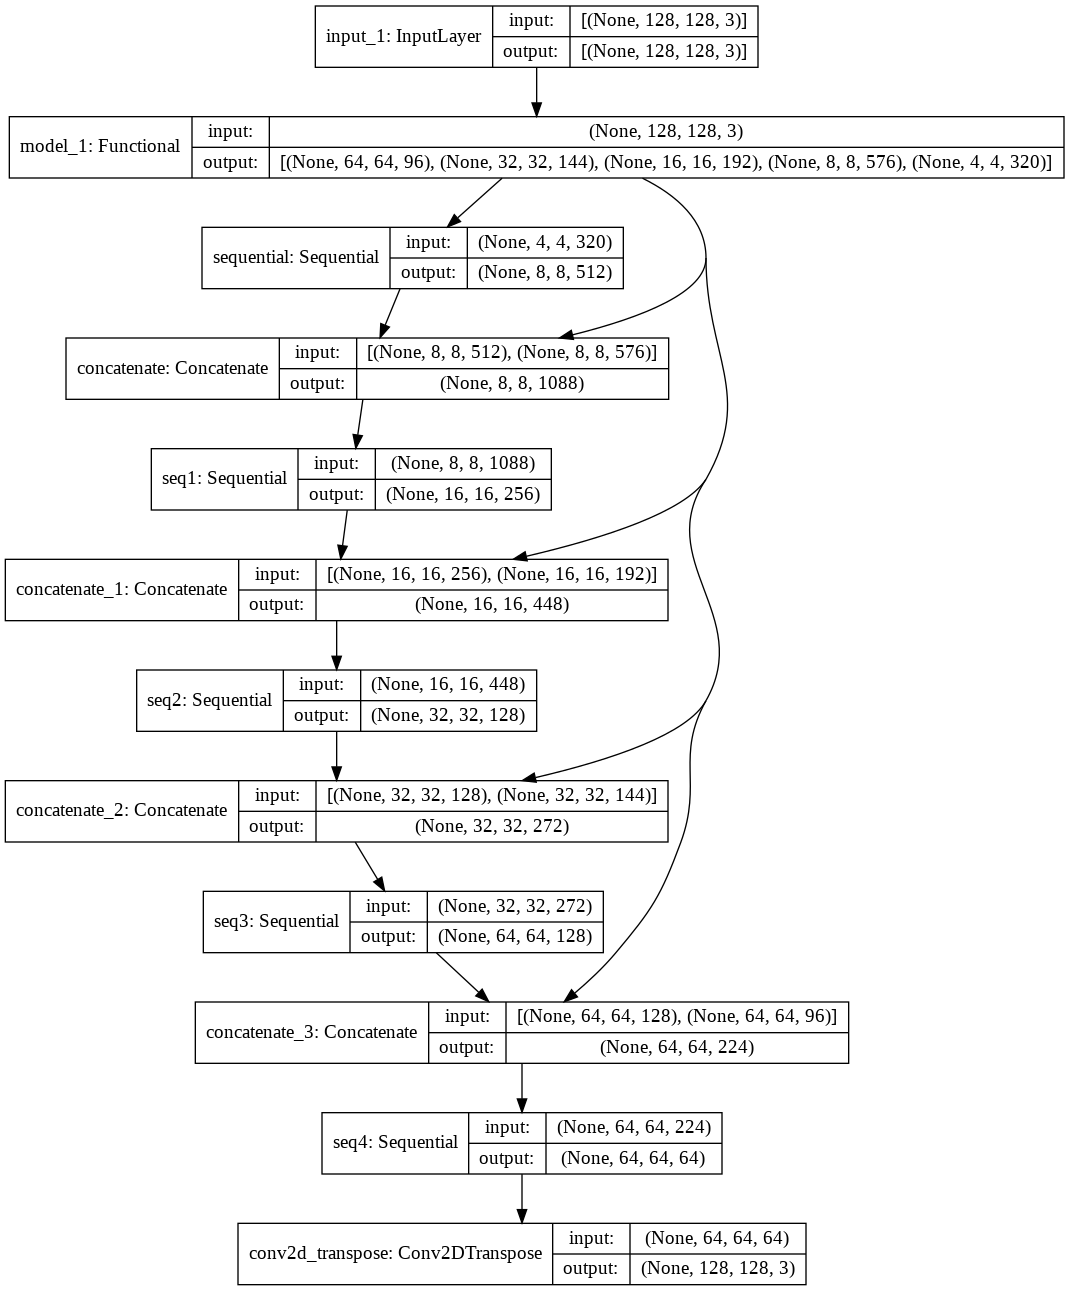

In [12]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(images_paths)
random.Random(1337).shuffle(masks_paths)
train_input_img_paths = images_paths[:-val_samples]
train_target_img_paths = masks_paths[:-val_samples]
val_input_img_paths = images_paths[-val_samples:]
val_target_img_paths = masks_paths[-val_samples:]

# Instantiate data Sequences for each split
batch_size = 32
train_gen = PetsSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [14]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")


# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 105s 321ms/step - loss: 56.7904 - val_loss: 0.7544
Epoch 2/15
199/199 [==============================] - 62s 313ms/step - loss: 0.4214 - val_loss: 0.3449
Epoch 3/15
199/199 [==============================] - 63s 317ms/step - loss: 0.2949 - val_loss: 0.2492
Epoch 4/15
199/199 [==============================] - 63s 316ms/step - loss: 0.2596 - val_loss: 0.2894
Epoch 5/15
199/199 [==============================] - 62s 313ms/step - loss: 0.2402 - val_loss: 0.2670
Epoch 6/15
199/199 [==============================] - 63s 317ms/step - loss: 0.2272 - val_loss: 0.2252
Epoch 7/15
199/199 [==============================] - 63s 313ms/step - loss: 0.2142 - val_loss: 0.2219
Epoch 8/15
199/199 [==============================] - 63s 315ms/step - loss: 0.2054 - val_loss: 0.2255
Epoch 9/15
199/199 [==============================] - 63s 316ms/step - loss: 0.1950 - val_loss: 0.2227
Epoch 10/15
199/199 [==============================] - 63s 317ms/step -

In [15]:
# predict segmentation for validation dataset
# It is not necessary to predict the result for the whole dataset, you can limit yourself to one bitch from the validation dataset 

val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

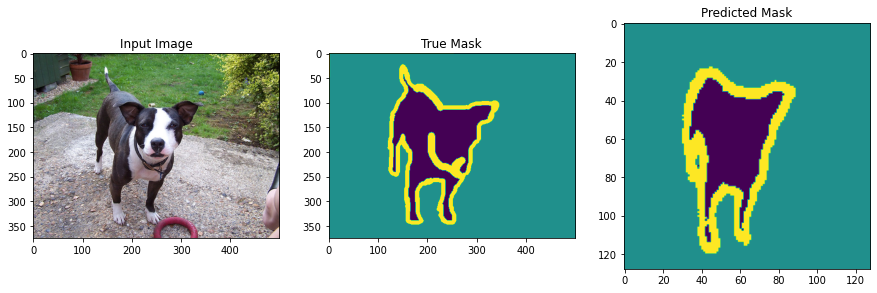

In [18]:
# display one sample prediction

i = 7

sample = load_image_and_mask(val_input_img_paths, val_target_img_paths, i)
prediction = prediction_to_img(val_preds[i])
sample += (prediction,)

display_sample(sample)

#### Task 4 (optional): Predict segmentation on your own pets



In [1]:
tests = get_paths("dir_with_tour_images/", "jpg")

x = np.zeros((batch_size, ) + img_size + (3, ), dtype="float32")

# Here you can use your code to load images and setting the x from Sequence.__getitem__

preds = model.predict(x)

NameError: ignored

In [ ]:
def display_segmentation(image, prediction):
    plt.figure(figsize=(15, 15))
    
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(np.asarray(image))
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(np.asarray(prediction))

In [ ]:
i = 2

image = load_img(tests[i], target_size=img_size)
prediction = prediction_to_img(preds[i])

display_segmentation(image, prediction)